In [1]:
# Installer les bibliothèques nécessaires
%pip install -q nltk vaderSentiment spacy torch tqdm

# Télécharger les modèles linguistiques de spaCy pour le français et l'anglais
import spacy

spacy.cli.download("fr_core_news_sm")  # Modèle pour le français
spacy.cli.download("en_core_web_sm")  # Modèle pour l'anglais

Note: you may need to restart the kernel to use updated packages.
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [2]:
import pandas as pd
import os
import nltk
import torch
from tqdm import tqdm
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.util import ngrams
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# ==========================
# 1️⃣ Chargement des Données
# ==========================
comments_path = "Data/Data_clean/Comments_clean.csv"

# Charger le DataFrame
comments_df = pd.read_csv(comments_path)

# Chemin du fichier Excel
lexicon_xlsx_path = "Data/Costum_lexicon.xlsx"

df_lexicon = pd.read_excel(lexicon_xlsx_path)

# Vérifier les colonnes
if "Sentiments" not in comments_df.columns:
    raise ValueError("La colonne 'Sentiments' est absente.")

In [4]:
# ==============================
# 2️⃣ Chargement des Modèles NLP
# ==============================
nltk.download("punkt")
nlp_fr = spacy.load("fr_core_news_sm")  # Modèle français
nlp_en = spacy.load("en_core_web_sm")   # Modèle anglais

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kikoo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
# ==========================================
# 3️⃣ Personnalisation de VADER avec bigrams
# ==========================================

# Charger le lexique personnalisé
custom_lexicon = {}
for _, row in df_lexicon.iterrows():
    word, score = row[0], row[1]  # Suppose que la 1ère colonne est le mot et la 2ème le score
    custom_lexicon[word] = float(score)

print("✅ Lexique personnalisé chargé avec succès !")

# Générer les bigrams et les ajouter au lexique
bigram_lexicon = {}
for phrase in custom_lexicon.keys():
    tokens = phrase.split()  # Séparer en mots
    if len(tokens) > 1:  # Si c'est un bigramme
        bigram_lexicon["_".join(tokens)] = custom_lexicon[phrase]  # Ajouter au lexique sous forme "mot1_mot2"

# Fusionner les deux lexiques
custom_lexicon.update(bigram_lexicon)

# Initialiser VADER avec le lexique personnalisé
analyzer = SentimentIntensityAnalyzer()
analyzer.lexicon.update(custom_lexicon)

✅ Lexique personnalisé chargé avec succès !


C:\Users\kikoo\AppData\Local\Temp\ipykernel_14164\2685530650.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  word, score = row[0], row[1]  # Suppose que la 1ère colonne est le mot et la 2ème le score


In [6]:
%pip install arabic-reshaper
%pip install python-bidi

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [7]:
# =================================================
# 4️⃣ Fonction de Tokenization (inclut les bigrams)
# =================================================
def tokenize_text(text, lang="fr"):
    """Tokenisation en mots et en bigrammes pour capturer le contexte."""
    if lang == "fr":
        doc = nlp_fr(text)
    else:
        doc = nlp_en(text)
    
    tokens = [token.text.lower() for token in doc if not token.is_punct]
    bigrams = ["_".join(bigram) for bigram in ngrams(tokens, 2)]  # Convertir les bigrams en format "mot1_mot2"
    
    return tokens + bigrams

print("✅ Lexique mis à jour avec les bigrammes !")

✅ Lexique mis à jour avec les bigrammes !


In [8]:
# ====================================
# 5️⃣ Fonction d'Annotation avec VADER
# ====================================
def analyze_sentiment(comment):
    """Analyse le sentiment d'un commentaire avec VADER en tenant compte des bigrams."""
    if not isinstance(comment, str) or comment.strip() == "":
        return "Neutre"

    tokens = tokenize_text(comment)  # Tokenisation en mots et bigrams
    modified_comment = " ".join(tokens)  # Reconstruire la phrase avec bigrams
    
    scores = analyzer.polarity_scores(modified_comment)
    if scores["compound"] >= 0.05:
        return "Positif"
    elif scores["compound"] <= -0.05:
        return "Negatif"
    else:
        return "Neutre"

In [9]:
# ====================================
# 6️⃣ Exécution en Parallèle avec CUDA
# ====================================
def process_comments_parallel(df):
    """Exécute l'annotation en parallèle avec CUDA."""
    if not torch.cuda.is_available():
        raise RuntimeError("CUDA n'est pas disponible. Veuillez vérifier votre installation de CUDA et votre GPU.")

    print("Utilisation de CUDA pour le traitement.")
    df["Predicted_Sentiment"] = [analyze_sentiment(comment) for comment in tqdm(df["Comments"])]

    return df


In [10]:
# =========================
# 7️⃣ Application du Modèle
# =========================
print("🔄 Annotation des sentiments...")
comments_df = process_comments_parallel(comments_df)

🔄 Annotation des sentiments...
Utilisation de CUDA pour le traitement.


100%|██████████| 3619/3619 [00:26<00:00, 137.45it/s]


✅ Matrice de confusion enregistrée dans : Results\confusion_matrix.png


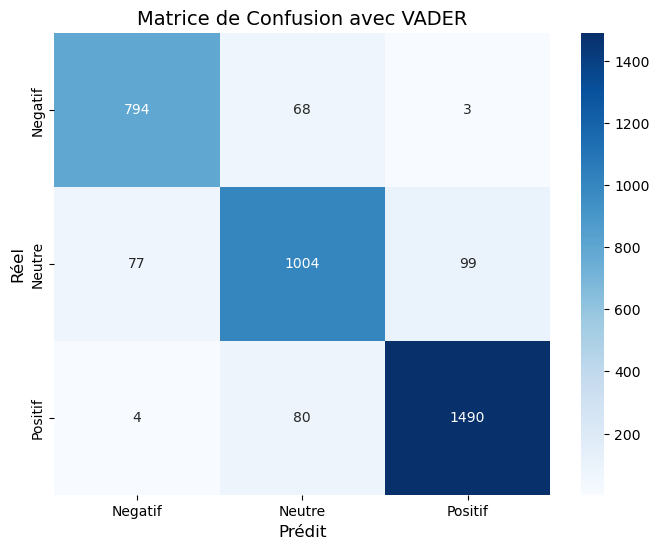

In [11]:
# ==============================
# 8️⃣ Évaluation des Résultats
# ==============================
y_true = comments_df["Sentiments"]
y_pred = comments_df["Predicted_Sentiment"]

output_dir = "Results"

# Calcul des métriques
accuracy = accuracy_score(y_true, y_pred) * 100  # Pourcentage
precision = precision_score(y_true, y_pred, average=None) * 100
recall = recall_score(y_true, y_pred, average=None) * 100

# Générer la matrice de confusion
labels = ["Negatif", "Neutre", "Positif"]
cm = confusion_matrix(y_true, y_pred, labels=labels)

# Tracer la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)

# Titres et labels
plt.title("Matrice de Confusion avec VADER", fontsize=14)
plt.xlabel("Prédit", fontsize=12)
plt.ylabel("Réel", fontsize=12)

# Sauvegarde de la Matrice
confusion_matrix_path = os.path.join(output_dir, "confusion_matrix.png")
plt.savefig(confusion_matrix_path)
print(f"✅ Matrice de confusion enregistrée dans : {confusion_matrix_path}")

# Afficher la matrice
plt.show()

In [12]:
# Affichage des résultats
print(f"\n✅ Accuracy du modèle sur l'ensemble de test : {round(accuracy, 2)} %\n")
report = classification_report(y_true, y_pred)
print(report)


✅ Accuracy du modèle sur l'ensemble de test : 90.85 %

              precision    recall  f1-score   support

     Negatif       0.91      0.92      0.91       865
      Neutre       0.87      0.85      0.86      1180
     Positif       0.94      0.95      0.94      1574

    accuracy                           0.91      3619
   macro avg       0.90      0.91      0.90      3619
weighted avg       0.91      0.91      0.91      3619



In [13]:
# ================================
# 9️⃣ Enregistrement des Résultats
# ================================
metrics_path = os.path.join(output_dir, "metrics_results_VADER.txt")
annotated_csv_path = os.path.join(output_dir, "Annotated_Comments_VADER.csv")

with open(metrics_path, "w") as f:
    f.write(f"🔍 Évaluation des Sentiments\n")
    f.write("=" * 50 + "\n")
    f.write(f"\n✅ Accuracy du modèle sur l'ensemble de test : {round(accuracy, 2)} %\n\n")
    f.write(report)

# Sauvegarde du DataFrame annoté
comments_df.to_csv(annotated_csv_path, index=False)

print(f"\n✅ Annotation terminée ! Résultats enregistrés dans : {annotated_csv_path}")
print(f"✅ Scores des métriques enregistrés dans : {metrics_path}")


✅ Annotation terminée ! Résultats enregistrés dans : Results\Annotated_Comments_VADER.csv
✅ Scores des métriques enregistrés dans : Results\metrics_results_VADER.txt
